In [3]:
import numpy as np
from pandas import Series
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt


In [14]:
def Identification_Algorithm(x):    #辨识算法
    B = np.array([[1]*2]*(len(x)-1))
    tmp = np.cumsum(x)
    for i in range(len(x)-1):
        B[i][0] = ( tmp[i] + tmp[i+1] ) * (-1.0) / 2
    Y = np.transpose(x[1:])
    BT = np.transpose(B)
    a = np.linalg.inv(np.dot(BT,B))
    a = np.dot(a,BT)
    a = np.dot(a,Y)
    a = np.transpose(a)
    return a;

In [18]:
def GM_Model(X0,a,tmp):          #GM(1,1)模型
    A = np.ones(len(X0))
    for i in range(len(A)):
        A[i] = a[1]/a[0] + (X0[0]-a[1]/a[0])*np.exp(a[0]*(tmp[i]-1)*(-1))
    print ('GM(1,1)模型为:\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    XK = Series(A,index=pd.period_range('2000','2016',freq = 'A-DEC'))   
    print ('GM(1,1)模型计算值为:')
    print (XK)
    return XK;

In [19]:
def Return(XK):                 #预测值还原
    tmp = np.ones(len(XK)) 
    for i in range(len(XK)):
        if i == 0:
            tmp[i] = XK[i]
        else:
            tmp[i] = XK[i] - XK[i-1]
    X_Return = Series(tmp,index=pd.period_range('2000','2016',freq = 'A-DEC'))
    print ('还原值为:\n')
    print (X_Return)
    return X_Return

原始数据为:

2000     938.21
2001     983.84
2002    1003.08
2003    1024.99
2004    1289.13
2005    1778.42
2006    1815.08
2007    1858.08
2008    1888.46
2009    1921.32
2010    2301.91
2011    2347.46
2012    2380.43
2013    2415.15
2014    2425.68
2015    2415.27
2016    2419.70
Freq: A-DEC, dtype: float64
原始数据累加为:
2000      938.21
2001     1922.05
2002     2925.13
2003     3950.12
2004     5239.25
2005     7017.67
2006     8832.75
2007    10690.83
2008    12579.29
2009    14500.61
2010    16802.52
2011    19149.98
2012    21530.41
2013    23945.56
2014    26371.24
2015    28786.51
2016    31206.21
Freq: A-DEC, dtype: float64
a矩阵为:
[2.33759527e-02 2.21361934e+03]
GM(1,1)模型为:
X(k) =  -93758.22308827535 exp( -0.023375952650378225 (k-1)) 94696.43308827536
GM(1,1)模型计算值为:
2000    -1279.294953
2001      938.210000
2002     3104.479830
2003     5220.698317
2004     7288.021890
2005     9307.580259
2006    11280.477031
2007    13207.790316
2008    15090.573314
2009    16929.854890
2010    1872

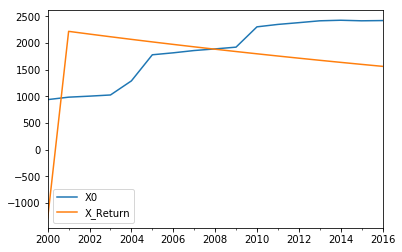

In [21]:
if __name__ == '__main__':
    #初始化原始数据
    date = pd.period_range('2000','2016',freq = 'A-DEC')#看做一个被划分为多个月度时期的时间段中的游标 december
    tmp = np.array([i for i in range(17)])
    data = np.array([938.21,983.84,1003.08,1024.99,1289.13,
                     1778.42,1815.08,1858.08,1888.46,1921.32,
                     2301.91,2347.46,2380.43,2415.15,2425.68,
                     2415.27,2419.7])
    X0 = Series(data,index = date)
    X0_copy = Series(data,index=tmp)
    print ('原始数据为:\n')
    print(X0)

    #对原始数据惊醒一次累加
    X1 = np.cumsum(X0)
    print ('原始数据累加为:')
    print(X1)

    #辨识算法
    a = Identification_Algorithm(data)
    print ('a矩阵为:')
    print (a)

    #GM(1,1)模型
    XK = GM_Model(X0,a,tmp)

    #预测值还原
    X_Return = Return(XK)

    #预测值即预测值精度表
    X_Compare1 = np.ones(len(X0))
    X_Compare2 = np.ones(len(X0))
    for i in range(len(data)):
        X_Compare1[i] = data[i]-X_Return[i]
        X_Compare2[i] = X_Compare1[i]/data[i]*100
    Compare = {'GM':XK,'1—AGO':np.cumsum(data),'Returnvalue':X_Return,'Realityvalue':data,'Error':X_Compare1,'RelativeError(%)':X_Compare2}
    X_Compare = DataFrame(Compare,index=date)
    print ('预测值即预测值精度表')
    print (X_Compare)

    #模型检验
    error_square = np.dot(X_Compare,np.transpose(X_Compare))    #残差平方和
    error_avg = np.mean(error_square)                           #平均相对误差

    S = 0                                                       #X0的关联度
    for i in range(1,len(X0)-1,1):
        S += X0[i]-X0[0]+(XK[-1]-XK[0])/2
    S = np.abs(S)

    SK = 0                                                      #XK的关联度
    for i in range(1,len(XK)-1,1):
        SK += XK[i]-XK[0]+(XK[-1]-XK[0])/2
    SK = np.abs(SK)

    S_Sub = 0                                                   #|S-SK|b
    for i in range(1,len(XK)-1,1):
        S_Sub += X0[i]-X0[0]-(XK[i]-XK[0])+((X0[-1]-X0[0])-(XK[i]-XK[0]))/2
    S_Sub = np.abs(S_Sub)

    T = (1+S+SK)/(1+S+SK+S_Sub)

    if T >= 0.9:
        print ('精度为一级')
        print ('可以用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    elif T >= 0.8:
        print ('精度为二级')
        print ('可以用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    elif T >= 0.7:
        print ('精度为三级')
        print ('谨慎用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    elif T >= 0.6:
        print ('精度为四级')
        print ('尽可能不用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])


#     X2006 = Series(np.array([259.4489]),index=pd.period_range('2006','2006',freq = 'A-DEC'))
#     X_Return = X_Return.append(X2006)
#     print (X_Return)

    B = pd.DataFrame([X0,X_Return],index=['X0','X_Return'])
    B = np.transpose(B)
    B.plot()